In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import scienceplots

plt.style.use("science")

## Preliminary data analysis

In [2]:
data_dir = "ESC-50-master"
df = pd.read_csv(os.path.join(data_dir, "meta", "esc50.csv"))
df["class"] = df["target"] // 10
df.head()

,filename,fold,target,category,esc10,src_file,take,class
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,1
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,3
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,3
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


In [3]:
data_dir = "ESC-50-master"
df = pd.read_csv(os.path.join(data_dir, "meta", "esc50.csv"))
df = df.query("esc10 == True").reset_index()

from sklearn.preprocessing import OneHotEncoder

categories = df["category"].to_numpy()

encoder = OneHotEncoder()
target = encoder.fit_transform(categories.reshape(-1, 1)).toarray()
df["target"] = target.tolist()
df["class"] = df["target"].apply(lambda x: np.argmax(x))

df.head()

,index,filename,fold,target,category,esc10,src_file,take,class
0,0,1-100032-A-0.wav,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",dog,True,100032,A,4
1,14,1-110389-A-0.wav,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",dog,True,110389,A,4
2,24,1-116765-A-41.wav,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",chainsaw,True,116765,A,0
3,54,1-17150-A-12.wav,1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",crackling_fire,True,17150,A,2
4,55,1-172649-A-40.wav,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",helicopter,True,172649,A,5


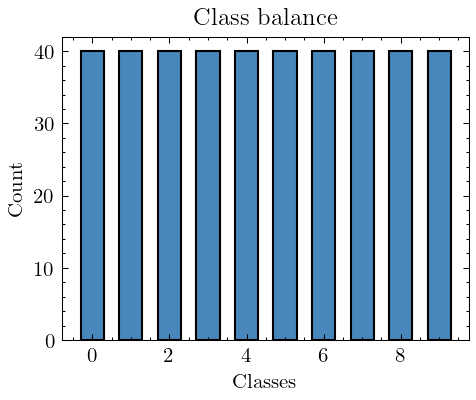

In [4]:
plt.figure(dpi=150)
sns.histplot(df, x="class", discrete=True, shrink=0.6)
plt.title("Class balance")
plt.xlabel("Classes")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "class_balance.png"), dpi=150)
plt.show()

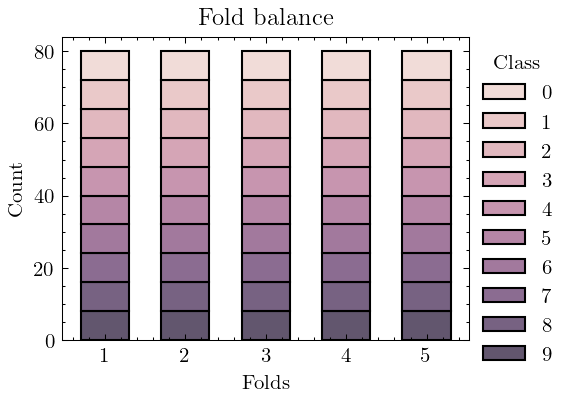

In [5]:
plt.figure(dpi=150)
sns.histplot(df, x="fold", hue="class", discrete=True, shrink=0.6, multiple="stack")
sns.move_legend(plt.gca(), loc="upper right", bbox_to_anchor=(1.25, 1), title="Class")
plt.title("Fold balance")
plt.xlabel("Folds")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "fold_balance.png"), dpi=150)
plt.show()

## Feature extraction

In [6]:
import torch
import torchaudio


class myPipeline(torch.nn.Module):
    def __init__(
        self,
        n_mfcc: int = 40,
        sample_rate=44100,
        mtWin=1,
        mtStep=0.5,
        stWin=0.02,
        stStep=0.01,
    ):
        super().__init__()
        self.n_mfcc = n_mfcc
        self.sample_rate = sample_rate
        self.mtWin = np.floor(mtWin * sample_rate).astype(int)
        self.mtStep = np.floor(mtStep * sample_rate).astype(int)
        self.stWin = np.floor(stWin * sample_rate).astype(int)
        self.stStep = np.floor(stStep * sample_rate).astype(int)

        self.mfcc = torchaudio.transforms.MFCC(
            sample_rate=self.sample_rate,
            n_mfcc=self.n_mfcc,
            melkwargs={"n_fft": 2048, "hop_length": 512},
            log_mels=True,
        )

    def windowize(self, waveform: torch.Tensor, win: int, step: int) -> torch.Tensor:
        mtWindows = waveform.unfold(1, win, step)
        return mtWindows

    def timeFeatExtraction(self, waveform: torch.Tensor) -> tuple[
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
    ]:
        mtWindows = self.windowize(waveform, self.mtWin, self.mtStep)
        mtZCR_mean = torch.zeros(mtWindows.shape[1])
        mtZCR_std = torch.zeros(mtWindows.shape[1])
        energy_mean = torch.zeros(mtWindows.shape[1])
        energy_std = torch.zeros(mtWindows.shape[1])
        energyEntropy_mean = torch.zeros(mtWindows.shape[1])
        energyEntropy_std = torch.zeros(mtWindows.shape[1])
        for i in range(mtWindows.shape[1]):
            mtWindow = mtWindows[:, i, :]
            stWindows = self.windowize(mtWindow, self.stWin, self.stStep)
            zcr = torch.zeros(stWindows.shape[1])
            energy = torch.zeros(stWindows.shape[1])
            energyEntropy = torch.zeros(stWindows.shape[1])
            for j in range(stWindows.shape[1]):
                stWindow = stWindows[:, j, :]
                # Zero Crossing Rate
                zcr[j] = (
                    1
                    / (2 * stWindow.shape[1])
                    * torch.sum(torch.abs(torch.diff(torch.sign(stWindow[0, :]))))
                )

                # Energy
                energy[j] = (1 / (len(stWindow))) * torch.sum(torch.abs(stWindow**2))

                # Energy entropy
                eps = 1e-8
                subFramesLen = 147
                subFrames = stWindow.reshape(1, -1, subFramesLen)
                subFramesEnergy = (
                    1 / subFramesLen * torch.sum(torch.abs(subFrames**2), dim=2)
                )
                subFramesEnergyNorm = subFramesEnergy / (
                    torch.sum(subFramesEnergy) + eps
                )
                energyEntropy[j] = -torch.sum(
                    subFramesEnergyNorm * torch.log2(subFramesEnergyNorm + eps)
                )

            mtZCR_mean[i] = torch.mean(zcr)
            mtZCR_std[i] = torch.std(zcr)
            energy_mean[i] = torch.mean(energy)
            energy_std[i] = torch.std(energy)
            energyEntropy_mean[i] = torch.mean(energyEntropy)
            energyEntropy_std[i] = torch.std(energyEntropy)

        ltZCR_mean = torch.mean(mtZCR_mean).unsqueeze(0)
        ltZCR_std = torch.mean(mtZCR_std).unsqueeze(0)
        ltenergy_mean = torch.mean(energy_mean).unsqueeze(0)
        ltenergy_std = torch.mean(energy_std).unsqueeze(0)
        ltenergyEntropy_mean = torch.mean(energyEntropy_mean).unsqueeze(0)
        ltenergyEntropy_std = torch.mean(energyEntropy_std).unsqueeze(0)

        return (
            ltZCR_mean,
            ltZCR_std,
            ltenergy_mean,
            ltenergy_std,
            ltenergyEntropy_mean,
            ltenergyEntropy_std,
        )

    def forward(self, waveform: torch.Tensor, sample_rate) -> torch.Tensor:
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(
                waveform, sample_rate, self.sample_rate
            )
        mfcc = self.mfcc(waveform).mean(dim=2).squeeze(0)
        timeFeatures = self.timeFeatExtraction(waveform)

        features = torch.cat(
            (
                mfcc,
                timeFeatures[0],
                timeFeatures[1],
                timeFeatures[2],
                timeFeatures[3],
                timeFeatures[4],
                timeFeatures[5],
            )
        )
        return features

In [7]:
n_features = 46
feature_extractor = myPipeline()
features = torch.zeros(len(df), n_features)
for i, row in tqdm(df.iterrows()):
    waveform, sample_rate = torchaudio.load(
        os.path.join(data_dir, "audio", row["filename"]),
    )
    features[i] = feature_extractor(waveform, sample_rate)

400it [00:24, 16.67it/s]


## PCA

array([0.24077821, 0.09379186])

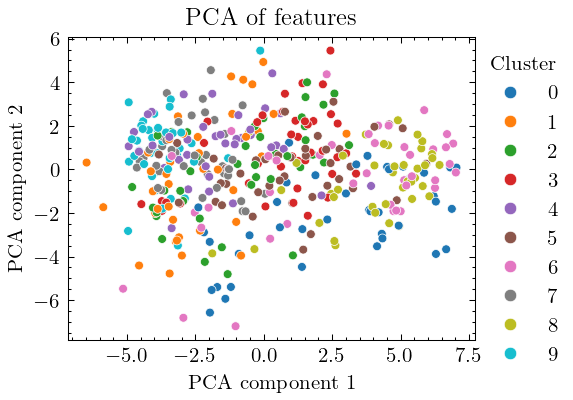

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize Features
scaler = StandardScaler()
features = scaler.fit_transform(features)

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)
display(pca.explained_variance_ratio_)

# Plot PCA
plt.figure(dpi=150)
ax = sns.scatterplot(
    x=features_pca[:, 0],
    y=features_pca[:, 1],
    hue=df["class"],
    palette="tab10",
    size=0.5,
    legend=True,
)
h, l = ax.get_legend_handles_labels()
ax.legend(h[:-1], l[:-1], title="Cluster", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.title("PCA of features")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "pca.png"), dpi=150)
plt.show()

### Clustering

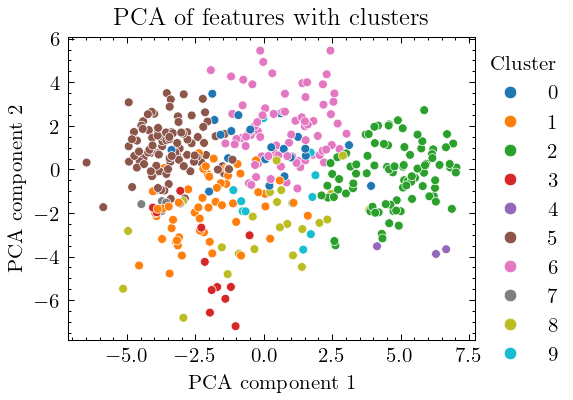

In [9]:
# Apply k-means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(features)

# Plot PCA with clusters
plt.figure(dpi=150)
ax = sns.scatterplot(
    x=features_pca[:, 0],
    y=features_pca[:, 1],
    hue=clusters,
    palette="tab10",
    legend=True,
    size=0.5,
)
h, l = ax.get_legend_handles_labels()
ax.legend(h[:-1], l[:-1], title="Cluster", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.title("PCA of features with clusters")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
os.makedirs("images", exist_ok=True)
plt.savefig(os.path.join("images", "pca_clusters.png"), dpi=150)
plt.show()

## Experiments

### KNN

Accuracy: 0.45 (+/- 0.08)


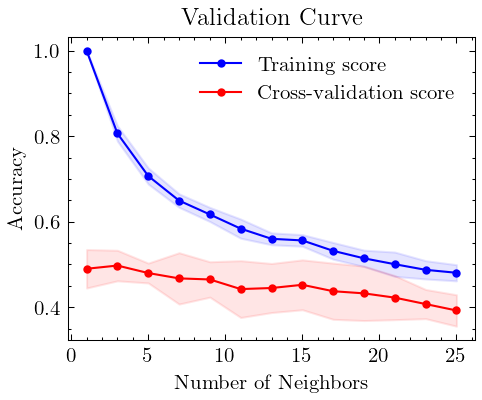

In [10]:
# Train a knn classifier on the features with onevsrest strategy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import validation_curve

X = features
y = df["class"]
knn = KNeighborsClassifier(n_neighbors=3)
clf = OneVsRestClassifier(knn)
scores = cross_val_score(clf, X, y, cv=5)
print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

param_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(),
    X,
    y,
    param_name="n_neighbors",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
)

# Calculate mean and standard deviation of training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation of test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(dpi=150)
plt.plot(
    param_range,
    train_mean,
    label="Training score",
    color="blue",
    marker="o",
    markersize=3,
)
plt.fill_between(
    param_range,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.1,
    color="blue",
)
plt.plot(
    param_range,
    test_mean,
    label="Cross-validation score",
    color="red",
    marker="o",
    markersize=3,
)
plt.fill_between(
    param_range,
    test_mean - test_std,
    test_mean + test_std,
    alpha=0.1,
    color="red",
)
plt.title("Validation Curve")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

### SVM

Accuracy: 0.67 (+/- 0.07)


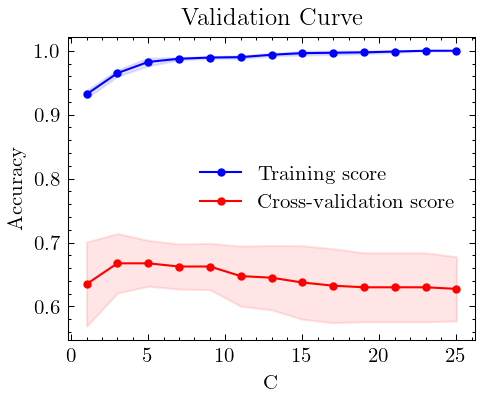

In [11]:
# Train an SVM with rbf kernel with onevsrest strategy
from sklearn.svm import SVC

X = features
y = df["class"]
clf = make_pipeline(OneVsRestClassifier(SVC(kernel="rbf", C=5)))
scores = cross_val_score(clf, X, y, cv=5)
print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

param_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
train_scores, test_scores = validation_curve(
    OneVsRestClassifier(SVC(kernel="rbf")),
    X,
    y,
    param_name="estimator__C",
    param_range=param_range,
    cv=5,
    scoring="accuracy",
)

# Calculate mean and standard deviation of training scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation of test scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(dpi=150)
plt.plot(
    param_range,
    train_mean,
    label="Training score",
    color="blue",
    marker="o",
    markersize=3,
)
plt.fill_between(
    param_range,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.1,
    color="blue",
)
plt.plot(
    param_range,
    test_mean,
    label="Cross-validation score",
    color="red",
    marker="o",
    markersize=3,
)
plt.fill_between(
    param_range,
    test_mean - test_std,
    test_mean + test_std,
    alpha=0.1,
    color="red",
)
plt.title("Validation Curve")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

### Simple MLP

In [12]:
# Train an MLP Classifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

X = features
y = df["class"]
clf = make_pipeline(
    MLPClassifier(
        hidden_layer_sizes=(70, 50, 50),
        max_iter=10000,
        n_iter_no_change=10,
        solver="sgd",
        activation="relu",
        learning_rate_init=0.01,
        random_state=42,
    ),
)
scores = cross_val_score(clf, X, y, cv=5)
print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Accuracy: 0.63 (+/- 0.13)
